In [1]:
import fastai
from fastai import *
from fastai.vision import *
import time
import utils

%matplotlib inline

In [2]:
print(f'FastAi: {fastai.__version__}')
print(f'Torch: {torch.__version__}')

FastAi: 1.0.52
Torch: 1.1.0


In [3]:
bs = 32  ## for out of memory
num_workers = 2  # set to 0 or 1 when using windows or kaggle
image_size = 224

# Importing data

In [4]:
# Read in train labels and split from stratified_split.ipynb
labels = pd.read_csv(utils.data_fp/'train_stratified_split.csv')
labels.head()

,Image,Id,validation
0,0000e88ab.jpg,w_f48451c,False
1,0001f9222.jpg,w_c3d896a,False
2,00029d126.jpg,w_20df2c5,False
3,00050a15a.jpg,new_whale,False
4,0005c1ef8.jpg,new_whale,False


In [5]:
val_idx = labels.index[labels.validation].to_list()
print(f'Number of images in validation: {len(val_idx)}')

Number of images in validation: 6020


## Create ImageDataBunch

In [8]:
tfms = get_transforms(flip_vert=False, max_zoom=1)  ## remove vertical and zooming
tfms  ## list of transformations done to the images. tfms[0] is for training and tfms[1] is for validation

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

In [9]:
src = (ImageList.from_df(path=utils.data_fp, df=labels, cols='Image', folder='train')
                     # images' filepath are in a dataframe with column name 'Image'
                    .split_by_idx(val_idx)
                    # validations are not random and determined by the row indices
                    .label_from_df(cols='Id')
                    # classes for the images are in a dataframe with column name 'Id'
                    .add_test_folder())
                    # images to be use for inferences to the kaggle competition
if verbose: print(f'Type({type(src)})')
if verbose : print(src)  # show a summary of the datasets

Type(<class 'fastai.data_block.LabelLists'>)
LabelLists;

Train: LabelList (19341 items)
x: ImageList
Image (3, 700, 1050),Image (3, 325, 758),Image (3, 497, 1050),Image (3, 525, 1050),Image (3, 525, 1050)
y: CategoryList
w_f48451c,w_c3d896a,w_20df2c5,new_whale,new_whale
Path: data;

Valid: LabelList (6020 items)
x: ImageList
Image (3, 600, 1050),Image (3, 492, 1050),Image (3, 590, 886),Image (3, 329, 1050),Image (3, 717, 984)
y: CategoryList
new_whale,new_whale,new_whale,new_whale,new_whale
Path: data;

Test: LabelList (7960 items)
x: ImageList
Image (3, 273, 906),Image (3, 768, 1050),Image (3, 701, 1050),Image (3, 272, 635),Image (3, 701, 1050)
y: EmptyLabelList
,,,,
Path: data


In [10]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.transform(tfms, 
                          size=size,
                          resize_method=ResizeMethod.PAD,
                          padding_mode=padding_mode)
                .databunch(bs=bs, num_workers=num_workers)
                # creates a dataloader
                .normalize(imagenet_stats))
                # normalize the whale images with imagenet's mean and std because we are using a pretrained model

In [11]:
data = get_data(image_size, bs, 'border')

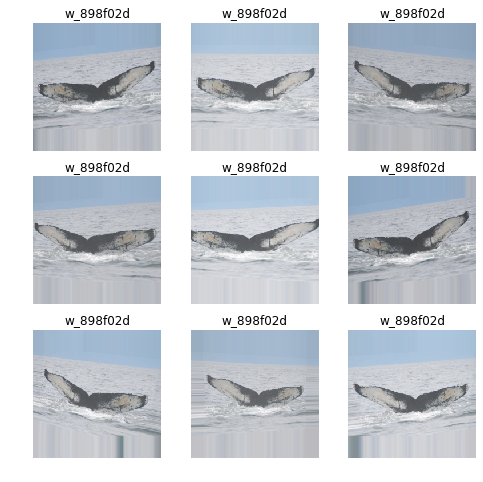

In [12]:
# Display examples of the transformation on a single image
def _plot(i,j,ax):
    x,y = data.train_ds[idx]
    x.show(ax,y=y)

idx = np.random.randint(len(data.train_ds))
plot_multi(_plot, 3, 3, figsize=(8,8))  ## show how the image is being transformed

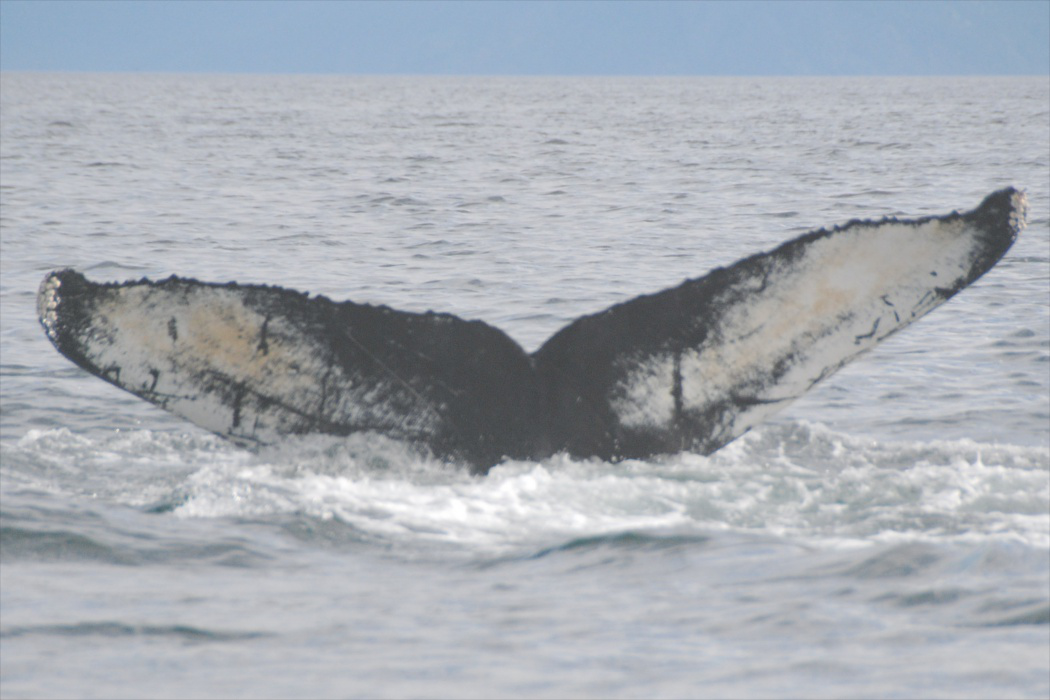

In [13]:
open_image(data.train_ds.items[idx]) # orginal image

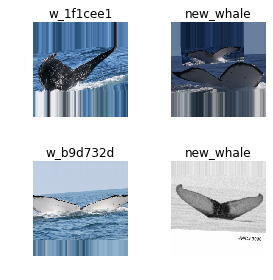

In [14]:
data.show_batch(rows=2, figsize=(4,4))  # this keeps crashing my computer